## ISEL - 5º Semestre 2024/25

#### <br>
# <center> Aprendizagem Automática (AA) </center>
##  <center> 2º Trabalho Laboratorial </center>
### <center> Classificação de Críticas de Cinema do IMDb </center>
#### </br>

### Grupo:
* Hugo Sousa, número <b> 46104 </b>
* João Fonseca, número <b> 49707 </b>
* Guilherme Vicente, número <b> 50745 </b>

### Docente:
* Engenheiro Gonçalo Marques

<b>Data de Entrega:</b> 22/12/2024

<b>Enunciado:</b> https://2425moodle.isel.pt/pluginfile.php/1265321/mod_resource/content/1/TP_imdb_24-25.pdf

---

<a id="indice"></a>
# Índice

- [Introdução](#intro)
- [Imports](#imp)
- [Desenvolvimento](#desenv)
    - [Preparação e Estudo dos Dados](#prep)
    - [Ridge](#rdg)
    - [Logistic Regression](#lrc)
- [Clustering](#clt)
- [Conclusões](#conc)
- [Bibliografia](#bib)

---

<a id="intro"></a>
# Introdução
A análise de sentimentos e a classificação de textos são áreas centrais na Aprendizagem Automática e no processamento de linguagem natural (NLP). Com o crescimento exponencial de dados textuais disponíveis online, tornou-se essencial desenvolver métodos eficazes para extrair informações significativas dessas fontes. Neste contexto, as críticas de cinema disponibilizadas pelo Internet Movie Database (**IMDb**) representam um recurso valioso para a investigação de técnicas de classificação, regressão e agrupamento de textos.  
Neste trabalho, utilizaremos um conjunto de dados, fornecidos pelo docente (`imdbFull.p`), composto por 50.000 críticas de cinema retiradas da base de dados do IMDb. Cada crítica está associada a uma pontuação que varia de 1 a 10, representando a avaliação do utilizador em relação ao filme. Críticas com pontuações neutras (5 e 6) foram excluídas para focar nas opiniões mais claras, sejam elas positivas ou negativas.

## Objetivos
O principal objetivo deste trabalho é desenvolver e avaliar modelos de aprendizagem automática que possam prever a pontuação das críticas de cinema do IMDb. Para alcançar este objetivo, o trabalho está dividido em três tarefas principais:

**Classificação Multi-classe**: Treinar e avaliar um classificador que prevê a pontuação da crítica.  
**Regressão**: Treinar e avaliar um regressor que prevê a pontuação da crítica.  
**Clustering**: Agrupar as críticas de forma não supervisionada para identificar padrões e tópicos comuns.  


## Metodologia
Para atingir os objetivos propostos, será adotada a seguinte abordagem:

- **Construção do Vocabulário**: Limpeza dos textos das críticas e técnicas de vetorização, como o `TfidfVectorizer`, para construir um vocabulário representativo.
- **Modelagem**:
    - **Classificação e Regressão**: Utilização do mesmo vocabulário para ambas as tarefas, selecionando modelos adequados para cada uma. Comparação dos desempenhos dos classificadores com os dos regressores, convertendo as predições dos modelos de regressão para uma escala de 1 a 10.  
    - **Avaliação de Desempenho**: Seleção das metodologias de teste apropriadas e utilização de métricas de desempenho específicas para cada tarefa (accuracy para classificação e erro médio absoluto para regressão).  
- **Clustering**: Aplicação de métodos de agrupamento para identificar grupos de críticas com tópicos específicos. Análise da variação no número de clusters e como isto afeta a performance dos algoritmos de agrupamento.  

---

<a id="imp"></a>
# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
import time
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix,accuracy_score, silhouette_score
from sklearn.cluster import KMeans

---

<a id="desenv"></a>
# Desenvolvimento

<a id="prep"></a>
## Preparação e Estudo dos Dados

In [2]:
D = pickle.load(open('imdbFull.p','rb'))
D.keys()

dict_keys(['data', 'target', 'DESCR'])

In [3]:
Docs   = D.data   # críticas
target = D.target # avaliações

- Docs é uma lista de stings que contém os textos das críticas de cinema.
- target é um NumPy array que contém as pontuações das críticas, numa escala de 1 a 10.

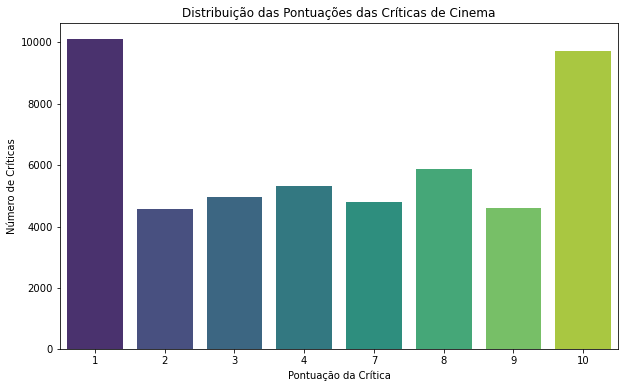

In [4]:
unique, counts = np.unique(target, return_counts=True)
plt.figure(figsize=(10,6))
sns.barplot(x=unique, y=counts, palette='viridis')
plt.xlabel('Pontuação da Crítica')
plt.ylabel('Número de Críticas')
plt.title('Distribuição das Pontuações das Críticas de Cinema')
plt.show()

A distribuição das pontuações revela um desbalanceamento nas classes, com maior concentração nas pontuações extremas. Essa distribuição demonstra que a maioria das opiniões tende a ser positiva ou negativa, com poucas críticas neutras. Isto pode ser benéfico para o número de acertos na avaliação, pois indica que estas críticas contêm palavras muito positivas ou muito negativas.

In [6]:
media         = np.mean(target)
desvio_padrao = np.std(target)
min_val       = np.min(target)
max_val       = np.max(target)

print(f"Média das Pontuações: {media:.2f}")
print(f"Desvio Padrão: {desvio_padrao:.2f}")
print(f"Pontuação Mínima: {min_val}")
print(f"Pontuação Máxima: {max_val}")

Média das Pontuações: 5.50
Desvio Padrão: 3.48
Pontuação Mínima: 1
Pontuação Máxima: 10


In [7]:
# Contagem
num_positivas = np.sum(target > 6)
num_negativas = np.sum(target < 5)

print(f"Número de Críticas Positivas (7-10): {num_positivas}")
print(f"Número de Críticas Negativas (1-4): {num_negativas}")

Número de Críticas Positivas (7-10): 25000
Número de Críticas Negativas (1-4): 25000


- Número Total de Críticas: 50.000
- A média das pontuações (5.50) indica uma distribuição equilibrada entre críticas positivas e negativas.
- O desvio padrão (3.48) mostra uma alta variabilidade nas pontuações, sugerindo uma ampla gama de opiniões dos usuários.
- O conjunto de dados está perfeitamente balanceado entre críticas positivas e negativas (50% cada), facilitando o treinamento de modelos de classificação sem a necessidade imediata de técnicas de balanceamento.

---

<a id="construct"></a>
## Construção do Vocabulário
A construção do vocabulário é essencial para o bom desempenho dos modelos. Um vocabulário bem construído permite que os modelos capturem as características mais relevantes dos textos das críticas, melhorando assim a precisão das tarefas de classificação, regressão e clustering. Neste capítulo, detalhamos os passos utilizados para construir o vocabulário a partir do conjunto de dados IMDb, incluindo a divisão em conjuntos de treino e teste, limpeza dos textos, aplicação de stemming e vetorização com TF-IDF.

### Divisão do Conjunto de Dados
Antes de iniciar o processamento textual, é essencial dividir o conjunto de dados em conjuntos de treino e teste. Essa divisão garante que o modelo seja treinado em uma parte dos dados e avaliado em outra, prevenindo overfitting e permitindo uma avaliação mais realista de seu desempenho.

### Limpeza dos Textos
A limpeza dos textos incide sobre a remoção de ruídos e preparação dos dados para análises subsequentes. Utilizamos a função limpar para substituir quebras de linha HTML e remover caracteres não alfabéticos, garantindo que os textos contenham apenas letras sem acentos.

In [7]:
def limpar(docs):
    """
    Limpa os documentos removendo caracteres indesejados.
    
    Argumentos:
    - docs: Lista de strings contendo os documentos a serem limpos.
    
    Retorna:
    - Lista de documentos limpos.
    """
    # Substituição de quebras de linha HTML por espaços
    d = [doc.replace('<br />',' ') for doc in docs]
    
    # Remoção de caracteres não alfabéticos (mantém apenas letras)
    # \u00C0-\u00FF remove caracteres com acentos
    d = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in d]
    return d

### Stemming
Stemming é o processo de reduzir as palavras ao seu radical, removendo sufixos e, em alguns casos, prefixos. Isso ajuda a normalizar o vocabulário, tratando variações de uma mesma palavra como uma única entidade. Realizamos o stemming antes da vetorização para garantir que diferentes formas de uma palavra sejam agrupadas adequadamente, melhorando a representação das características.  

Existem vários algoritmos de stemming:
- **Porter Stemmer**: Oferece um bom equilíbrio entre simplicidade e precisão, removendo sufixos comuns com eficácia.
- **Snowball Stemmer**: Uma extensão do Porter Stemmer que suporta múltiplos idiomas e é mais flexível.
- **Lancaster Stemmer**: Mais agressivo na remoção de sufixos, resultando em radicais mais curtos e, às vezes, menos precisos.

Foi escolhido o Porter Stemmer, por oferecer um bom equilíbrio entre remoção de sufixos e preservação do significado das palavras.

In [9]:
def stemming(docs):
    """
    Aplica o Porter Stemmer nos documentos.
    
    Argumentos:
    - docs: Lista de strings.
    
    Retorna:
    - Lista de documentos com palavras reduzidas ao radical.
    """
    stemmer      = PorterStemmer()
    docs_stemmed = [' '.join([stemmer.stem(w) for w in doc.split()]) for doc in docs]
    return docs_stemmed

### Vetorização com TF-IDF
`TfidVectorizer`: é uma ferramenta do scikit-learn utilizada para converter uma coleção de documentos de texto numa matriz de características numéricas. Combina duas etapas principais:

- **Term Frequency (TF)**: Mede a frequência de uma palavra num documento.
- **Inverse Document Frequency (IDF)**: Mede a importância de uma palavra em todo o corpus, reduzindo o peso de palavras comuns e aumentando o peso de palavras raras.  

A combinação de TF e IDF resulta no TF-IDF, que ajuda a destacar palavras que são importantes para um documento específico, mas que não são comuns em todo o conjunto de dados. Quanto mais alto for o TF-IDF, mais importante é essa palavra, aproximando-se de 0 quando esta for menos relevante.  

In [11]:
def vetorizacao(docs):
    """
    Vetoriza os documentos utilizando TF-IDF.
    
    Argumentos:
    - docs: Lista de strings.
    
    Retorna:
    - tfidf: Objeto TfidfVectorizer treinado.
    - tokens: Lista de tokens extraídos pelo TfidfVectorizer.
    """
    tfidf = TfidfVectorizer(
        min_df        = 4,             # Considera tokens que aparecem em pelo menos 4 documentos
        ngram_range   = (1,2),         # Bi-gramas
        token_pattern = r'\b\w\w\w+\b' # Tokens com 3 ou mais caracteres
    ).fit(docs)
    
    tokens = tfidf.get_feature_names_out()
    return tfidf, tokens

### Salvar os Vocabulários
O processo de treino dos modelos de vetorização, como o TfidfVectorizer, é computacionalmente dispendioso e demorado, especialmente em conjuntos de dados grandes como o IMDb, que contém 50.000 críticas. Para otimizar o fluxo de trabalho e evitar a repetição desnecessária do processo de vetorização, é necessário salvar os vocabulários limpos e os objetos treinados do TfidfVectorizer em ficheiros pickle. Isso permite reutilizar os vocabulários e os vetorizadores treinados em diferentes partes do projeto sem a necessidade de reprocessar os dados a cada execução.

In [13]:
# Construção do vocabulário
# Divisão em treino e teste (50% treino, 50% teste)
Docs_train, Docs_test, y_train, y_test = train_test_split(Docs, target, test_size=0.5, random_state=42)
inicio = time.time()

# Dados de Treino
docs1 = limpar(Docs_train) # Limpar
pickle.dump(docs1, open("dados_limpos.p",'wb'))
docs1 = stemming(docs1)    # Stemming
pickle.dump(docs1, open("dados_stem.p",'wb'))
#tfidf_train, tokens_train = vetorizacao(docs1) # Vetorização

fim = time.time()
print(f"Tempo de execução: {fim-inicio:.2f} segundos")

Tempo de execução: 89.53 segundos


O tempo necessário para fazer todo o processo de limpeza do conjunto de treino, foi de 71 segundos. Posto isto, é útil a gravação dos documentos num ficheiro pickle para mais tarde reutilizar.

In [47]:
print('Crítica Inicial: \n', Docs_train[0])
print('-'*120)
print('Crítica Após Limpeza: \n', docs1[0])

Crítica Inicial: 
 Wow, I just LOVED watching all these hot babes! The scenery around Malibu and California was off the fizzy. I could watch it again just to see all that flesh crammed into those tiny, teeny bikinis! I recently saw Pilar Lastra, the steaming hot housekeeper in Malibu Spring Break, as a center fold in my favorite mag, PLAYBOY. She is hot, hot HOT! The opening seen was bitchin. When the two main girls run out of gas and stop at this desert gas station, they drive the gas-guy nuts with their bodies and skimpy outfits! The slow-mo lets me enjoy every inch of them! My girlfriend liked looking at this shredded hot dude too (now I'd like a bod like that) and at all the other hot dudes....and some of the girls too! Any movie that can bring that out in my girlfriend is a 10 + for me!
------------------------------------------------------------------------------------------------------------------------
Crítica Após Limpeza: 
 wow i just love watch all these hot babe the sceneri

In [30]:
# Testar diferentes parâmetros para TF-IDF
# Parâmetros a testar
dfs = [1, 2, 3, 4, 5]  # Frequências mínimas de palavras
tps = [
    r'\b\w\w+\b',        # Tokens com 2 ou mais caracteres
    r'\b\w\w\w+\b',      # Tokens com 3 ou mais caracteres
    r'\b\w\w\w\w+\b',    # Tokens com 4 ou mais caracteres
    r'\b\w\w\w\w\w+\b',  # Tokens com 5 ou mais caracteres
    r'\b\w\w\w\w\w\w+\b' # Tokens com 6 ou mais caracteres
]
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # Unigramas, bigramas e trigramas

# Combinações de parâmetros a serem testadas
combos = [(df, tp, ngram) for df in dfs for tp in tps for ngram in ngram_ranges]

# Obtenção dos modelos TF-IDF e contagem do vocabulário
def testar_parametros(docs):
    resultados = []
    for (df, tp, ngram) in combos:
        tfidf = TfidfVectorizer(min_df=df, token_pattern=tp, ngram_range=ngram)
        tfidf.fit(docs)
        vocab_size = len(tfidf.get_feature_names_out())  # Tamanho do vocabulário
        resultados.append((df, tp, ngram, vocab_size))
    return resultados

# Executar teste nos documentos de treino
inicio = time.time()
resultados_tokens = testar_parametros(docs1)
fim = time.time()

# Exibir os resultados
print(f"Teste concluído em {fim - inicio:.2f} segundos")
for res in resultados_tokens:
    print(f"min_df: {res[0]}, token_pattern: {res[1]}, ngram_range: {res[2]}, vocab_size: {res[3]}")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Teste concluído em 621.32 segundos
min_df: 1, token_pattern: \b\w\w+\b, ngram_range: (1, 1), vocab_size: 51498
min_df: 1, token_pattern: \b\w\w+\b, ngram_range: (1, 2), vocab_size: 1274944
min_df: 1, token_pattern: \b\w\w+\b, ngram_range: (1, 3), vocab_size: 4721098
min_df: 1, token_pattern: \b\w\w\w+\b, ngram_range: (1, 1), vocab_size: 51016
min_df: 1, token_pattern: \b\w\w\w+\b, ngram_range: (1, 2), vocab_size: 1382373
min_df: 1, token_pattern: \b\w\w\w+\b, ngram_range: (1, 3), vocab_size: 4663711
min_df: 1, token_pattern: \b\w\w\w\w+\b, ngram_range: (1, 1), vocab_size: 48938
min_df: 1, token_pattern: \b\w\w\w\w+\b, ngram_range: (1, 2), vocab_size: 1449519
min_df: 1, token_pattern: \b\w\w\w\w+\b, ngram_range: (1, 3), vocab_size: 4228203
min_df: 1, token_pattern: \b\w\w\w\w\w+\b, ngram_range: (1, 1), vocab_size: 43482
min_df: 1, token_pattern: \b\w\w\w\w\w+\b, ngram_range: (1, 2), vocab_size: 1139491
min_df: 1, token_pattern: \b\w\w\w\w\w+\b, ngram_range: (1, 3), vocab_size: 2875013
m

Os resultados anteriores mostram como diferentes combinações de parâmetros afetam o tamanho do vocabulário gerado.  
- `min_df`:
  - Valores baixos (1, 2), geram vocabulários muito grandes, o que pode incluir ruído (palavras raras ou irrelevantes);
  - Valores médios (3, 4), reduzem o vocabulário sem sacrificar muito a semântica das palavras;
  - Para um balanço entre qualidade e tamanho, será escolhido um `min_df=4`.
- `token_pattern`:
  - Tokens com 2 caracteres resultam num vocabulário muito grande, incluindo palavras muito curtas que, geralmente, são menos informativas;
  - Tokens com 5 ou mais caracteres (`\b\w\w\w\w\w+\b`) geram vocabulários menores, focando em palavras mais relevantes, no entanto, podem excluir palavras curtas úteis;
  - Para redução do vocabulário, sem perder termos importantes, escolheremos um `token_pattern=r'\b\w\w\w+\b'`.
- `ngram_range`:
  - Unigramas (1,1), foca em palavras individuais.
  - Uni e Bigramas (1,2), aumenta significativamente o tamanho do vocabulário, mas captura relações entre palavras adjacentes.
  - Uni, Bi e Trigramas (1,3), gera vocabulários demasiado grandes, dificultando o treino.
  - Será então escolhido um `ngram_range=(1,2)` para a captura de informações textuais sem o crescimento excessivo do vocabulário.
  
Podemos observar que, com a escolha destes parâmetros, o tamanho do vocabulário é de 159661 tokens.

In [19]:
inicio = time.time()
Docs_train, Docs_test, y_train, y_test = train_test_split(Docs, target, test_size=0.5, random_state=42)

# Dados de treino
tfidf_train, token_train = vetorizacao(docs1)
pickle.dump(tfidf_train, open("tfidf_train.p",'wb'))
pickle.dump(token_train, open("tokens_train.p",'wb'))

# Dados de teste
docs2 = limpar(Docs_test) # Limpar
pickle.dump(docs2, open("dados_limpos_test.p",'wb'))
docs2 = stemming(docs2)   # Stemming
pickle.dump(docs2, open("dados_stem_test.p",'wb'))

fim = time.time()
print(f"Tempo de execução: {fim-inicio:.2f} segundos")

Tempo de execução: 109.70 segundos


In [21]:
X1 = tfidf_train.transform(docs1)
pickle.dump(X1, open("X_train.p",'wb'))
X2 = tfidf_train.transform(docs2)
pickle.dump(X2, open("X_test.p",'wb'))
# Matrizes esparsas X1 e X2 com shape (dim_dados, dim_vocabulario)

In [13]:
Docs_train, Docs_test, y_train, y_test = train_test_split(Docs, target, test_size=0.5, random_state=42)

docs1       = pickle.load(open('dados_stem.p','rb'))
tfidf_train = pickle.load(open('tfidf_train.p','rb'))
token_train = pickle.load(open('tokens_train.p','rb'))
docs2       = pickle.load(open('dados_stem_test.p','rb'))
X1          = pickle.load(open('X_train.p','rb'))
X2          = pickle.load(open('X_test.p','rb'))

X1 e X2 são matrizes esparsas (documento-termo) de dimensão (25000, 159661)
- 25000 documentos
- 159661 palavras no vocabulário

In [12]:
print(X1.shape, type(X1))

(25000, 159661) <class 'scipy.sparse.csr.csr_matrix'>


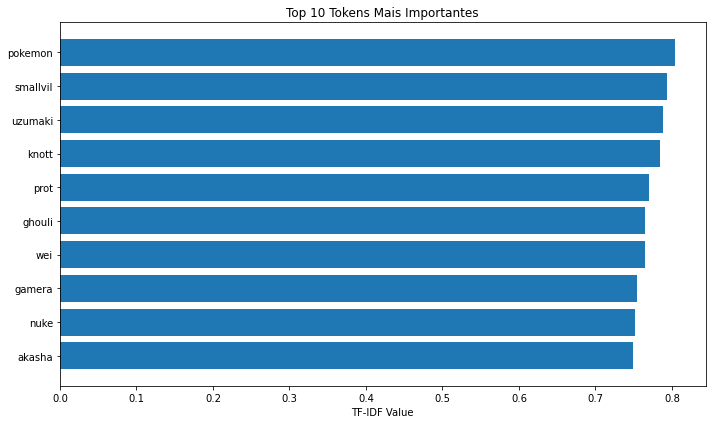

In [70]:
# Obter os valores máximos para cada token
xM = np.max(X1, axis=0).toarray().squeeze()
idx = np.argsort(-xM)  # Ordenar os índices pelo valor máximo (descendente)
voc = [token_train[i] for i in idx]  # Tokens ordenados pela importância

# Selecionar os 10 tokens mais importantes
top_10_tokens = voc[:10]
top_10_values = xM[idx[:10]]

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.barh(top_10_tokens[::-1], top_10_values[::-1], align='center')  # Gráfico horizontal
plt.xlabel('TF-IDF Value')
plt.title('Top 10 Tokens Mais Importantes')
plt.tight_layout()
plt.show()

In [68]:
# Quantas palavras no voc são uni gramas ou bi gramas
wC=np.array([len(w.split()) for w in voc])
print('Dimensão do vocabulário:',X1.shape[1])
print('Número de uni-gramas:',np.sum(wC==1))
print('Número de bi-gramas:',np.sum(wC==2))

Dimensão do vocabulário: 159661
Número de uni-gramas: 20079
Número de bi-gramas: 139582


---

<a id="rdg"></a>
<a id="lrg"></a>
## Classificação e regressão

Escolhémos um classificador e uma regresão e fizémos o teste para definir quais os melhores parâmetros. O regressor escolhido foi o Ridge e o classificador o LogisticRegression. Para testar quais os melhoreshiperparâmetros, utilizámos GridSearchCV para testar quais os melhores hiperparâmetros para o modelo. 

**Ridge**:
- Parâmetro 𝛼:
  - Valores baixos: Menor penalização e por consequente permite ao modelo ajustar-se aos dados. Maior probabilidade de ocorrer em overfitting
  - Valores altos: Maior penalização, simplificando-o mas havendo a probabilidade de entrar em underfitting


**Logistic Regression**:  
- Penalty Types:
  - `l1`: Aplica a regularização L1 (Lasso), que incentiva a esparsidade nos coeficientes, ou seja, tende a reduzir alguns coeficientes a exatamente zero, torna do o modelo mais interpretável.
  - `l2`: Aplica a regularização L2 (Ridge), que reduz os valores dos coeficientes, mas sem os tornar exatamente zero. É útil para prevenir o overfitting.
- Parâmetro C:
  - Valores baixos: aumentam a penalização, simplificando o modelo e diminuindo a probabilidade de ocorrer overfitting
  - Valores altos: permite uma maior flexibilidade para o modelo se ajustar aos dados


In [15]:
def convert_to_class(value):
    if 4 <= value <= 5.5:
        return 4
    elif 5.5 < value <= 7:
        return 7
    else:
        return round(value)

In [27]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X1, y_train, test_size=0.2, random_state=42)

ridge_model = Ridge()

ridge_param_grid = {'alpha': [0.1, 1.0, 10.0]}

ridge_search = GridSearchCV(ridge_model, ridge_param_grid, scoring='neg_mean_squared_error', cv=5)

ridge_search.fit(X_train_split, y_train_split)

print(f"Melhores parâmetros para Ridge: {ridge_search.best_params_}")

ridge_model = ridge_search.best_estimator_ 

# Treinar o melhor modelo com os dados completos
ridge_model.fit(X_train_split, y_train_split)

y_pred_rg = ridge_model.predict(X_val)

# Converter previsões contínuas para classes
y_pred_rgc = [convert_to_class(pred) for pred in y_pred_rg]


mc_rg = confusion_matrix(y_val, y_pred_rgc)
mse_rg = mean_squared_error(y_val, y_pred_rg)
r2_rg = r2_score(y_val, y_pred_rg)


print("Ridge ")
print("Matriz de confusão:\n ", mc_rg)
print("MSE: ", mse_rg)
print("R^2: ", r2_rg, "\n")

lr_model = LogisticRegression(max_iter=500)

lr_param_grid = {
    'C':[0.1],
    'penalty':['l1','l2']
}

lr_search = GridSearchCV(lr_model, lr_param_grid, scoring='accuracy', cv=5)
lr_search.fit(X_train_split, y_train_split)

print(f"Melhores parâmetros para Logistic Regression: {lr_search.best_params_}")

best_lr_model = lr_search.best_estimator_
best_lr_model.fit(X_train_split, y_train_split)
lr_pred_class = best_lr_model.predict(X_val)

print("\nLogistic Regression :")
print("Precisao: ",accuracy_score(y_val, lr_pred_class))
print("Matriz de confusão:\n", confusion_matrix(y_val, lr_pred_class))

Melhores parâmetros para Ridge: {'alpha': 1.0}
Ridge 
Matriz de confusão:
  [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   2  21  57 132 214 257 276  49   2   2   0   0   0   0]
 [  1   0   5   9  40  74 102 210  29   0   0   0   0   0   0]
 [  0   0   3   4  18  65  87 250  76   5   1   0   0   0   0]
 [  0   0   0   4  14  29  83 263 120   7   1   0   0   0   0]
 [  0   0   0   0   1   2   3  83 240  95  42   8   0   0   0]
 [  0   0   0   1   0   0   0  42 268 154  85  21   2   2   0]
 [  0   0   0   0   0   0   3  37 172 145  96  35   8   2   0]
 [  0   0   0   0   0   0   5  33 302 240 221 100  31   8   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _check_

Melhores parâmetros para Logistic Regression: {'C': 0.1, 'penalty': 'l2'}

Logistic Regression :
Precisao:  0.3676
Matriz de confusão:
 [[924   0   0   1   0   2   0  85]
 [407   0   0   3   0   1   0  59]
 [376   0   0   9   0   5   0 119]
 [309   0   0  25   0  10   0 177]
 [ 92   0   0  13   1  31   0 337]
 [ 82   0   0   2   0  30   0 461]
 [ 57   0   0   1   0  20   0 420]
 [ 76   0   0   2   0   5   0 858]]


Tendo em conta os resultados podemos concluir que o Ridge é melhor dos dois

In [30]:
ridge = Ridge(alpha= 1.0)
lr = LogisticRegression(C=0.1,penalty='l2')

ridge.fit(X1,y_train)
lr.fit(X1, y_train)

yRg_pred = ridge.predict(X2)
yLr_pred = lr.predict(X2)

In [48]:
yLr_pred_class = [convert_to_class(pred) for pred in yLr_pred]
yRg_pred_class = [convert_to_class(pred) for pred in yRg_pred]

print("Logistic Regression: ")
print("Precisão: ", accuracy_score(y_test, yLr_pred_class))
print("Matriz de confusão: \n", confusion_matrix(y_test, yLr_pred_class))


print("\n \n Ridge: ")
print("MSE: ", mean_squared_error(y_test, yRg_pred))
print("R^2: ", r2_score(y_test, yRg_pred))
print("Precisão: ", accuracy_score(y_test, yRg_pred_class))
print("Matriz de confusão: \n",confusion_matrix(y_test, yRg_pred_class))

Logistic Regression: 
Precisão:  0.37664
Matriz de confusão: 
 [[4646    0    0   13    0    6    0  360]
 [1917    0    0   34    1   16    0  301]
 [1780    0    0  114    4   46    0  511]
 [1560    0    0  229    3   85    0  812]
 [ 452    0    0   98   16  236    0 1653]
 [ 348    0    0   31   10  185    0 2348]
 [ 220    0    0   17    3   85    0 1948]
 [ 475    0    0    4    5   88    0 4340]]

 
 Ridge: 
MSE:  4.137961807216111
R^2:  0.6574986900695412
Precisão:  0.24004
Matriz de confusão: 
 [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   2    8   37  148  347  742 1009 1227 1267  215   16    7    

Tendo em conta os resultados obtidos podemos concluir que no processo de classificação LogisticRegression é melhor relativamente ao Ridge por ter uma maior precisão. Tivemos ainda algumas limitações na definição dos melhores hiperparâmetros para o LogisticRegression, pois tivemos de diminuir o número de hiperparâmetros a ter em conta para ser possível que este corresse em tempo útil.

<a id="clt"></a>
## Clustering

O K-Means é um algoritmo simples de aprendizagem não supervisionada, que tem o objetivo de dividir em k clusters, em que cada ponto de dados pertence ao centróide mais próximo.
O algoritmo segue os seguintes passos:
 - Escolhe aleatoriamente k centróides
 - A cada um dos pontos é atribuído um cluster cujo centróide esteja mais próximo
 - É feita uma atualização dos centróides, sendo estes recalculado
Estes passos repetem-se até que os centróides não mudem de posição ou o número máximo de iterações seja atingido


**Inércia:**
Esta métrica avalia se os dados estão bem agrupados em relação ao seu centróide através da seguinte fórmula:
$$
\text{Inércia} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2
$$



O método do cotovelo foi utilizado para determinar qual o número ideal de clusters

Text(0.5, 1.0, 'Método do Cotovelo')

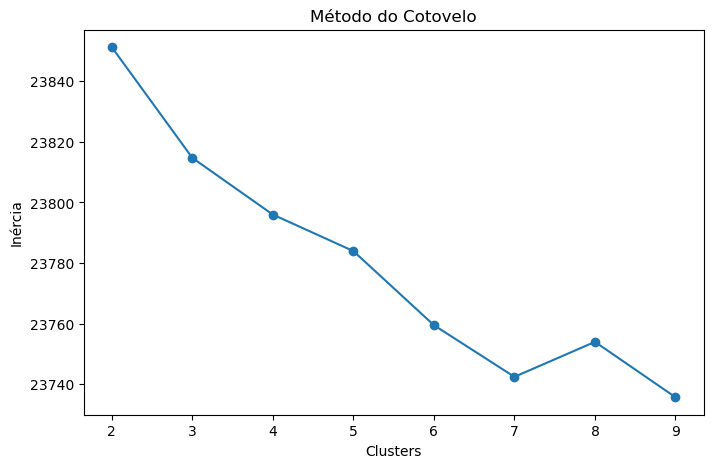

In [38]:
inercia = []
valores_K = range(2,10)

for k in valores_K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X1)  # Use sua matriz TF-IDF
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(valores_K, inercia, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')

In [39]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X1)
labels = kmeans.labels_

In [40]:
tfidf_cluster, tokens_cluster = vetorizacao(docs1)
terms = tfidf_cluster.get_feature_names_out()  # Supondo que 'tfidf' é o vectorizer
for i in range(k):
    print(f"Cluster {i}:")
    cluster_center = kmeans.cluster_centers_[i]
    top_terms = cluster_center.argsort()[-10:][::-1]  # Top 10 termos
    print([terms[t] for t in top_terms])

Cluster 0:
['the', 'worst', 'movi', 'the worst', 'thi', 'and', 'ever', 'seen', 'ever seen', 'worst movi']
Cluster 1:
['the', 'her', 'she', 'and', 'that', 'with', 'thi', 'for', 'but', 'film']
Cluster 2:
['the', 'and', 'thi', 'that', 'you', 'movi', 'for', 'with', 'film', 'but']
Cluster 3:
['the', 'movi', 'and', 'thi', 'thi movi', 'that', 'you', 'the movi', 'but', 'not']
Cluster 4:
['the', 'and', 'film', 'thi', 'that', 'for', 'with', 'but', 'are', 'the film']
Cluster 5:
['the', 'and', 'that', 'film', 'thi', 'with', 'for', 'movi', 'but', 'are']


In [41]:
for k in [5, 6, 8]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X1)
    score = silhouette_score(X1, labels)
    print(f"Silhouette Score para k={k}: {score:.4f}")

Silhouette Score para k=5: -0.0024
Silhouette Score para k=6: -0.0042
Silhouette Score para k=8: -0.0046


<a id="conc"></a>
# Conclusões

Neste trabalho explorámos diferentes maneiras de classificar critícas de cinema utilizandos técnicas de aprendizagem auotmático supervisionada e não supervisionada. Na classificação utilizámos o LogisticRegression e na regressão o Ridge, que se evidanciaram não só pelos resultados diferentes que obtivemos de cada um mas também no tempo de execução destes. 
Em suma, durante a realização deste trabalho conseguimos entender melhor as capacidades e limitações da aprendizagem supervisionada e não supervisionada.

---

<a id="bib"></a>
# Bibliografia
* Slides das aulas
* Scikit-learn User Guide (https://scikit-learn.org/stable/user_guide.html)
* Scikit-learn Ridge (https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.Ridge.html)
* Scikit-learn LogisticRegression (https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)

* [Voltar ao início](#indice)

---